In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

from keras.models import Sequential
from keras.layers import LSTM, Dense

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Utility functions

In [ ]:
def convert_time_to_seconds(time_str):
    parts = time_str.split(':')
    if len(parts) == 3:
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(float(parts[2]))
    if len(parts) == 2:
        return int(parts[0]) * 60 + int(float(parts[1]))
    return time_str  # Or handle differently if desired

def convert(some_data):
  some_data[some_data == '--'] = np.nan
  some_data = np.nan_to_num(some_data)
  some_data = some_data.astype(np.float32)

  return some_data

def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Function to identify and label outliers using Z-scores
def detect_outliers(column):
    mean = column.mean()
    std = column.std()
    z_scores = (column - mean) / std
    return abs(z_scores) > z_score_threshold

## Functions for evaluation

In [ ]:
def plot_evaluation(y_test, y_pred):
  plt.figure(figsize=(15,6))
  plt.plot(y_test, label="Actual Values", color='blue')
  plt.plot(y_pred, label="Predictions", color='red')
  plt.title("Actaul vs Predicted")
  plt.legend()
  plt.show()


def evaluate_regression(y_true, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    explained_var = explained_variance_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)

    # Create a dictionary to store the metrics
    metrics_dict = {
        'Mean Squared Error (MSE)': mse,
        'Mean Absolute Error (MAE)': mae,
        'Root Mean Squared Error (RMSE)': rmse,
        'R-squared (R2)': r2,
        'Explained Variance Score': explained_var,
        'Median Absolute Error (MedAE)': medae
    }

    return metrics_dict

### Translation

In [ ]:
translation_dict = {
    'Typ aktywności': 'Activity Type',
    'Data': 'Date',
    'Ulubiony': 'Favorite',
    'Tytuł': 'Title',
    'Dystans': 'Distance',
    'Kalorie': 'Calories',
    'Czas': 'Time',
    'Średnie tętno': 'Avg HR',
    'Maksymalne tętno': 'Max HR',
    'Aerobowy TE': 'Areobic TE',
    'Średni rytm biegu': 'Avg Run Cadence',
    'Maksymalny rytm biegu': 'Max Run Cadence',
    'Średnie tempo': 'Avg Pace',
    'Najlepsze tempo': 'Best Pace',
    'Całkowity wznios': 'Total Ascent',
    'Całkowity spadek': 'Total Descent',
    'Średnia długość kroku': 'Avg Stride Length',
    'Średnie odchylenie do długości': 'Avg Vertical Ratio',
    'Średnie odchylenie pionowe': 'Avg Vertical Oscillation',
    'Średni czas kontaktu z podłożem': 'Avg Ground Contact Time',
    'Średni GAP': 'Avg Ground Angular Power',
    'Normalized Power® (NP®)': 'Normalized Power (NP)',
    'Training Stress Score® (TSS®)': 'Training Stress Score®',
    'Średnia moc': 'Avg Power',
    'Maksymalna moc': 'Max Power',
    'Trudność': 'Grit',
    'Płynność': 'Flow',
    'Średni Swolf': 'Avg. Swolf',
    'Średnie tempo ruchów': 'Avg Stroke Rate',
    'Razem powtórzeń': 'Total Reps',
    'Czas nurkowania': 'Dive Time',
    'Minimalna temperatura': 'Min Temp',
    'Przerwa powierzchniowa': 'Surface Interval',
    'Dekompresja': 'Decompression',
    'Czas najlepszego okrążenia': 'Best Lap Time',
    'Liczba okrążeń': 'Number of Laps',
    'Maksymalna temperatura': 'Max Temp',
    'Czas ruchu': 'Moving Time',
    'Upłynęło czasu': 'Elapsed Time',
    'Minimalna wysokość': 'Min Elevation',
    'Maksymalna wysokość': 'Max Elevation',
    'Średnia częstotliwość oddechu': 'Avg Breath',
    'Minimalna częstotliwość oddechu': 'Min Breath',
    'Maksymalna częstotliwość oddechu': 'Max Breath'
}

## Load the data

In [ ]:
PATH = '/content/Activities.csv'
#PATH = '/content/Zawolski-dane-biegowe-Garmin.csv'
#PATH = '/content/Activities (2).csv'

In [ ]:
df = pd.read_csv(PATH)

In [ ]:
df.head().T

0                    1  \
Activity Type                         Running              Running   
Date                      2023-09-28 07:38:09  2023-09-27 07:51:44   
Favorite                                False                False   
Title                        Czernica Running     Czernica Running   
Distance                                12.01                 7.05   
Calories                                  453                  285   
Time                                 01:05:17             00:40:11   
Avg HR                                    135                  138   
Max HR                                    158                  168   
Avg Run Cadence                           182                  175   
Max Run Cadence                           191                  184   
Avg Pace                                 5:26                 5:42   
Best Pace                                5:00                 3:07   
Total Ascent                               94                    6   
Total Descent                              50                   70   
Avg Stride Length                        1.01                  1.0   
Avg Vertical Ratio                        0.0                  0.0   
Avg Vertical Oscillation                  0.0                  0.0   
Avg Ground Contact Time                     0                    0   
Training Stress Score®                    0.0                  0.0   
Avg Power                                   0                    0   
Max Power                                   0                    0   
Grit                                      0.0                  0.0   
Flow                                      0.0                  0.0   
Avg. Swolf                                  0                    0   
Avg Stroke Rate                             0                    0   
Total Reps                                  0                    0   
Dive Time                                0:00                 0:00   
Min Temp                                  0.0                  0.0   
Surface Interval                         0:00                 0:00   
Decompression                              No                   No   
Best Lap Time                        00:04.59             00:06.93   
Number of Laps                             13                   27   
Max Temp                                  0.0                  0.0   
Moving Time                          01:05:01             00:39:46   
Elapsed Time                         01:06:02             00:40:11   
Min Elevation                             -37                   58   
Max Elevation                              47                  122   

                                            2                    3  \
Activity Type                         Running              Running   
Date                      2023-09-27 07:38:17  2023-09-25 07:17:53   
Favorite                                False                False   
Title                        Czernica Running     Czernica Running   
Distance                                  2.1                12.04   
Calories                                  122                  439   
Time                                 00:12:23             01:08:34   
Avg HR                                    152                  129   
Max HR                                    166                  161   
Avg Run Cadence                           180                  180   
Max Run Cadence                           186                  194   
Avg Pace                                 5:53                 5:42   
Best Pace                                4:40                 3:35   
Total Ascent                              113                  101   
Total Descent                              31                   34   
Avg Stride Length                        0.94                 0.97   
Avg Vertical Ratio                        0.0                  0.0   
Avg Vertical Oscillation                  0.0        

In [ ]:
df.columns

Index(['Activity Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg HR', 'Max HR', 'Avg Run Cadence', 'Max Run Cadence',
       'Avg Pace', 'Best Pace', 'Total Ascent', 'Total Descent',
       'Avg Stride Length', 'Avg Vertical Ratio', 'Avg Vertical Oscillation',
       'Avg Ground Contact Time', 'Training Stress Score®', 'Avg Power',
       'Max Power', 'Grit', 'Flow', 'Avg. Swolf', 'Avg Stroke Rate',
       'Total Reps', 'Dive Time', 'Min Temp', 'Surface Interval',
       'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp',
       'Moving Time', 'Elapsed Time', 'Min Elevation', 'Max Elevation'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Type             1183 non-null   object 
 1   Date                      1183 non-null   object 
 2   Favorite                  1183 non-null   bool   
 3   Title                     1183 non-null   object 
 4   Distance                  1183 non-null   float64
 5   Calories                  1183 non-null   object 
 6   Time                      1183 non-null   object 
 7   Avg HR                    1183 non-null   int64  
 8   Max HR                    1183 non-null   int64  
 9   Avg Run Cadence           1183 non-null   object 
 10  Max Run Cadence           1183 non-null   object 
 11  Avg Pace                  1183 non-null   object 
 12  Best Pace                 1183 non-null   object 
 13  Total Ascent              1183 non-null   object 
 14  Total De

In [ ]:
df.isna().sum()

Activity Type               0
Date                        0
Favorite                    0
Title                       0
Distance                    0
Calories                    0
Time                        0
Avg HR                      0
Max HR                      0
Avg Run Cadence             0
Max Run Cadence             0
Avg Pace                    0
Best Pace                   0
Total Ascent                0
Total Descent               0
Avg Stride Length           0
Avg Vertical Ratio          0
Avg Vertical Oscillation    0
Avg Ground Contact Time     0
Training Stress Score®      0
Avg Power                   0
Max Power                   0
Grit                        0
Flow                        0
Avg. Swolf                  0
Avg Stroke Rate             0
Total Reps                  0
Dive Time                   0
Min Temp                    0
Surface Interval            0
Decompression               0
Best Lap Time               0
Number of Laps              0
Max Temp  

# Data preparation

In [ ]:
df.rename(columns=translation_dict, inplace=True)

In [ ]:
df = df[::-1].reset_index(drop=True)

In [ ]:
df = df.drop(columns=['Activity Type', 'Favorite', 'Title', 'Dive Time', 'Avg Vertical Ratio', 'Avg Vertical Oscillation',
       'Avg Ground Contact Time', 'Training Stress Score®', 'Avg Power',
       'Max Power', 'Grit', 'Flow', 'Avg. Swolf', 'Avg Stroke Rate',
       'Total Reps', 'Dive Time', 'Min Temp', 'Surface Interval',
       'Decompression',  'Best Lap Time', 'Number of Laps', 'Max Temp', 'Elapsed Time', 'Min Elevation', 'Max Elevation'])

In [ ]:
columns_to_drop = ['Areobic TE','Avg Ground Angular Power', 'Normalized Power (NP)', 'Avg Breath', 'Min Breath', 'Max Breath']

In [ ]:
df_columns  = df.columns

for i in df_columns:
  for j in columns_to_drop:
    if i == j:
      df = df.drop(i, axis=1)

In [ ]:
df.columns

Index(['Date', 'Distance', 'Calories', 'Time', 'Avg HR', 'Max HR',
       'Avg Run Cadence', 'Max Run Cadence', 'Avg Pace', 'Best Pace',
       'Total Ascent', 'Total Descent', 'Avg Stride Length', 'Moving Time'],
      dtype='object')

In [ ]:
df['Avg Run Cadence'] = pd.to_numeric(df['Avg Run Cadence'], errors='coerce')
df['Max Run Cadence'] = pd.to_numeric(df['Max Run Cadence'], errors='coerce')
df['Total Ascent'] = pd.to_numeric(df['Total Ascent'], errors='coerce')
df['Total Descent'] = pd.to_numeric(df['Total Descent'], errors='coerce')
df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')

In [ ]:
df['Moving Time'] = df['Moving Time'].apply(convert_time_to_seconds)
df['Avg Pace'] = df['Avg Pace'].apply(convert_time_to_seconds)
df['Best Pace'] = df['Best Pace'].apply(convert_time_to_seconds)

In [ ]:
df['Avg Pace'] = pd.to_numeric(df['Avg Pace'], errors='coerce')
df['Best Pace'] = pd.to_numeric(df['Best Pace'], errors='coerce')

In [ ]:
# Convert the 'Date' column to a datetime type and Unix timestamps
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].astype(int) // 10**9

# EDA

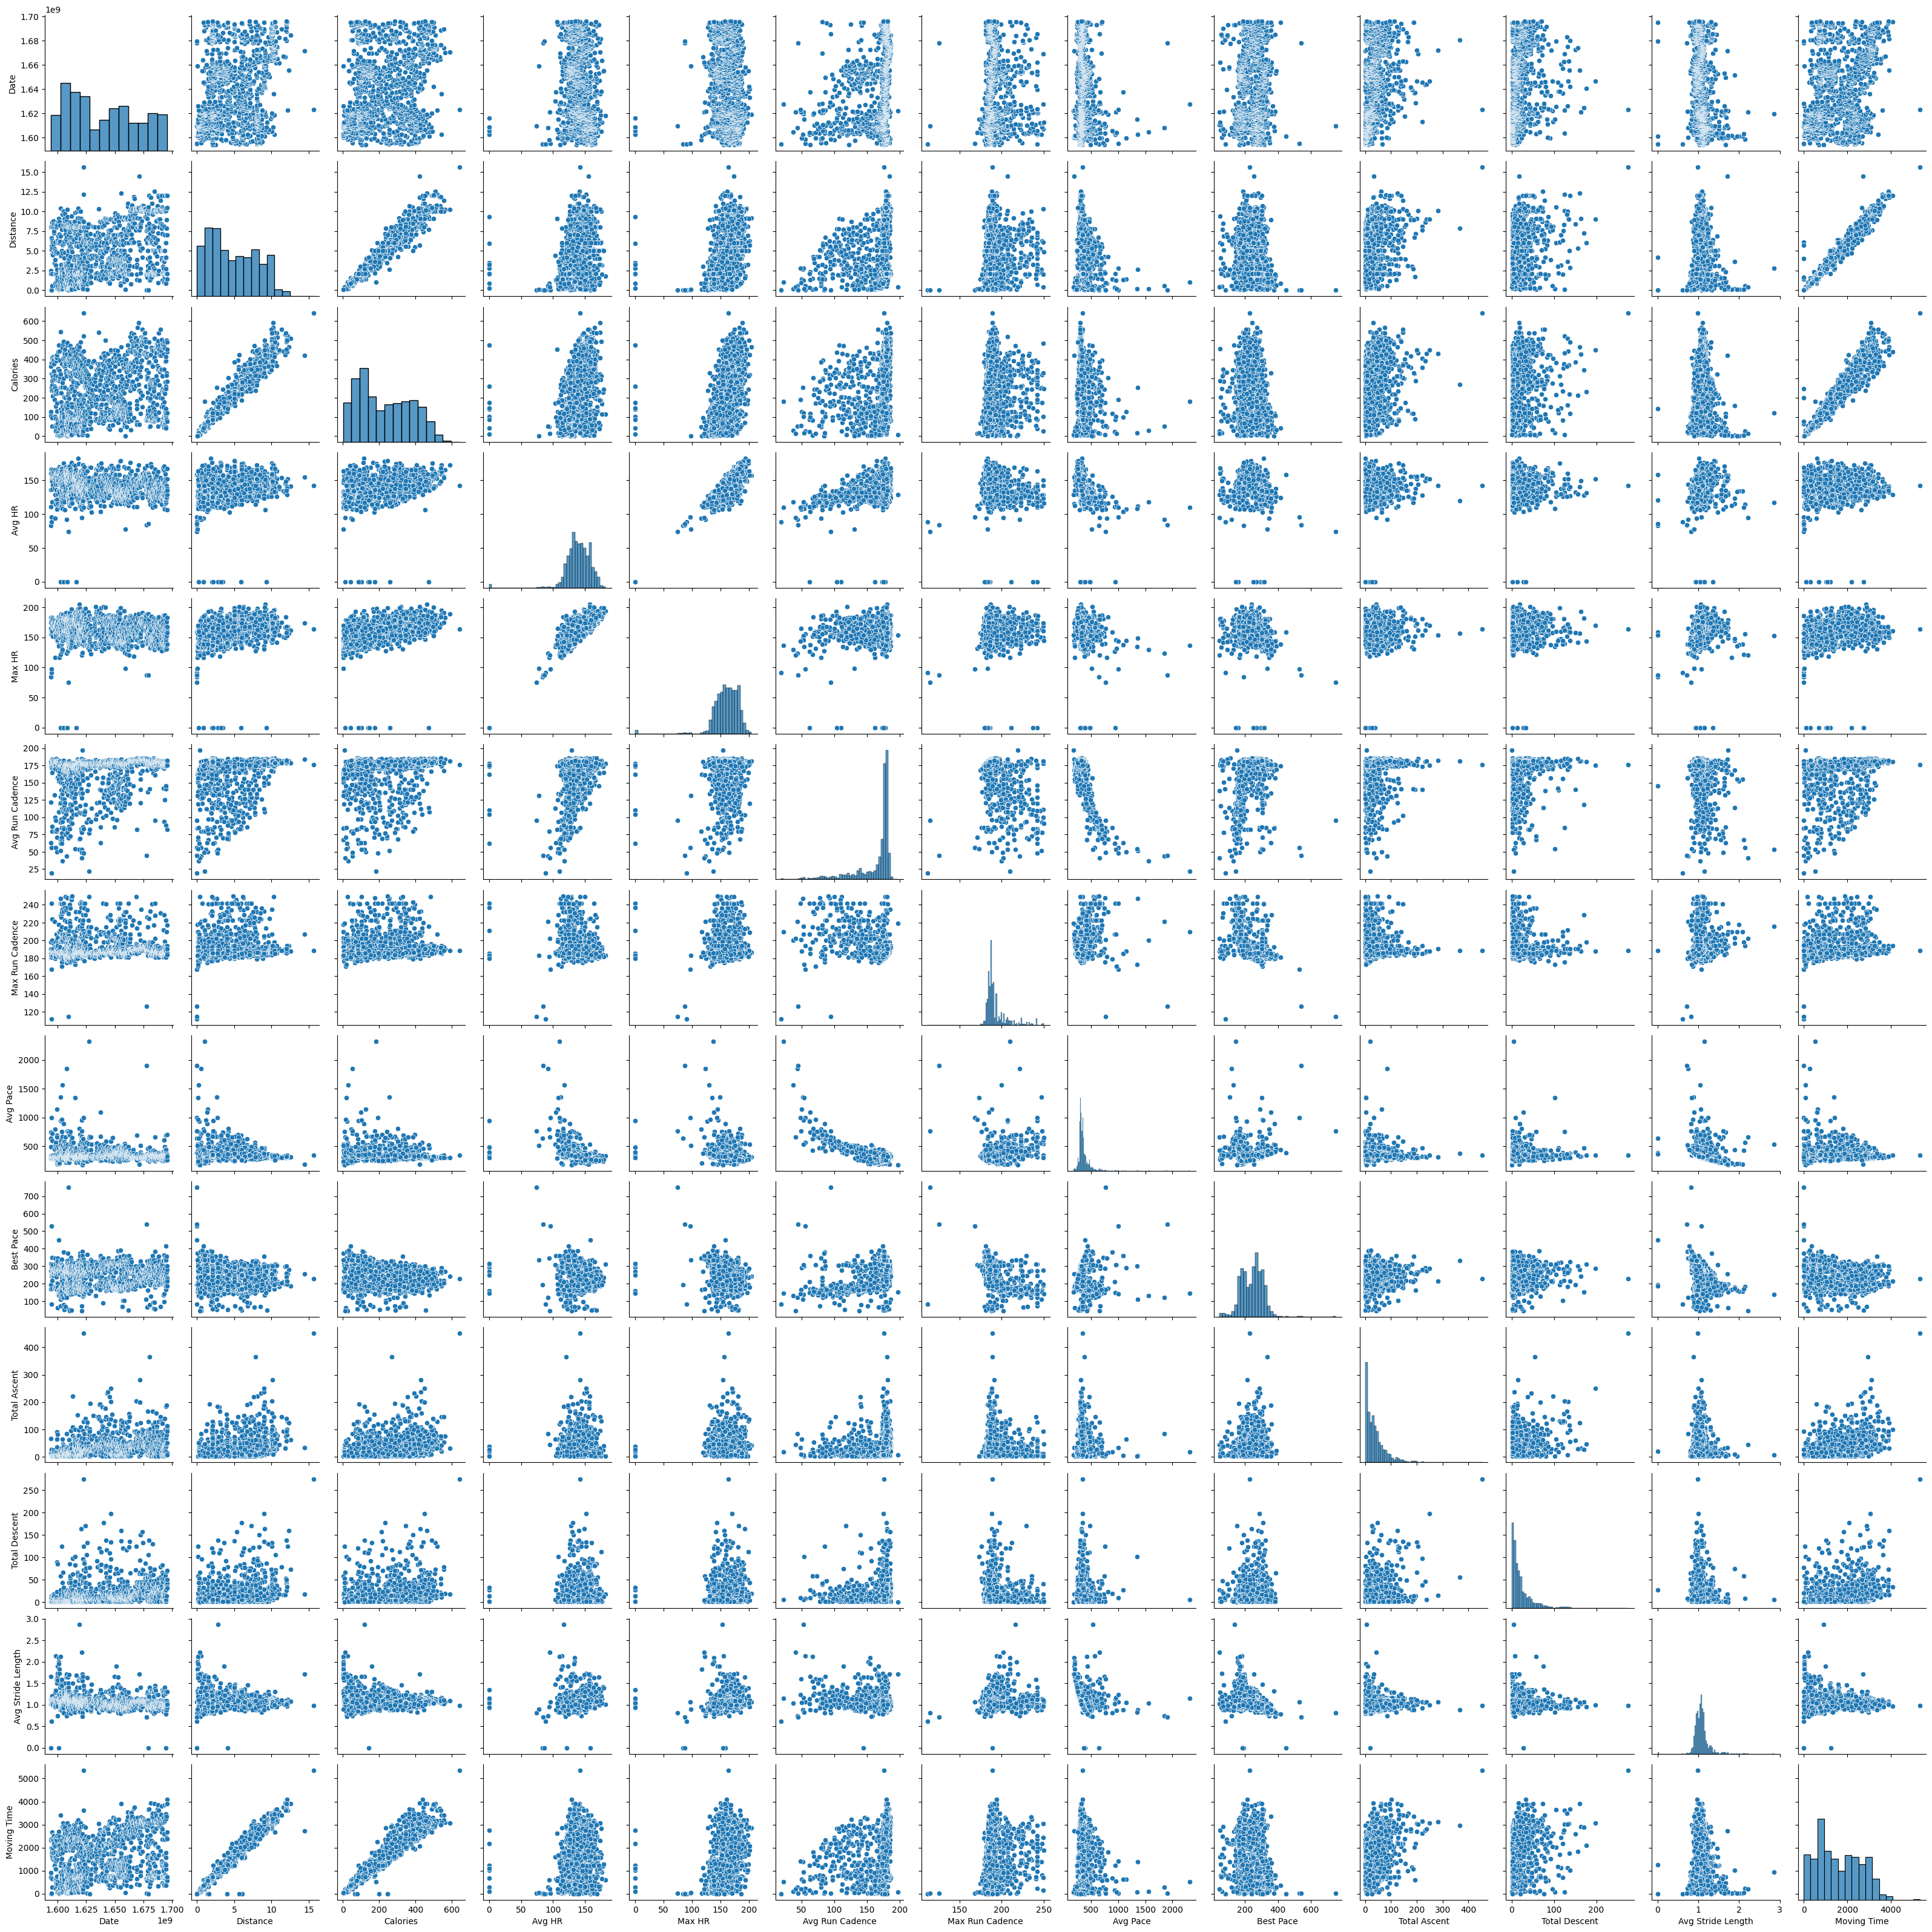

In [ ]:
sns.pairplot(df)

<ipython-input-194-326c0bf4e80d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_numeric = df.corr()


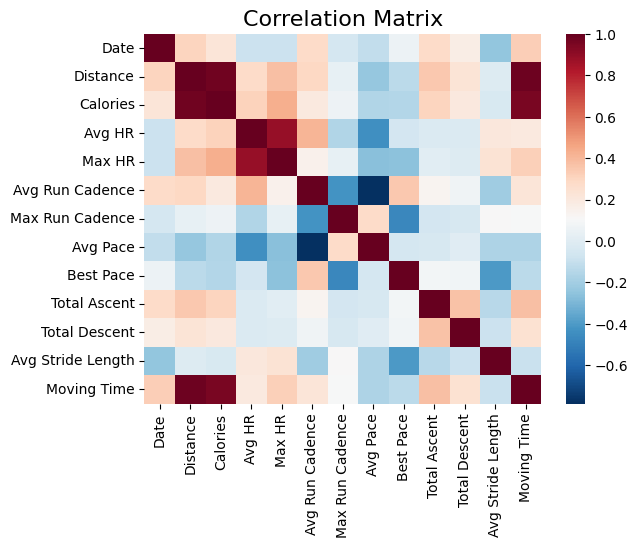

In [ ]:
corr_numeric = df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

<ipython-input-157-3e051500d043>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corrwith(df['Avg Pace']).sort_values(ascending = False).to_frame()


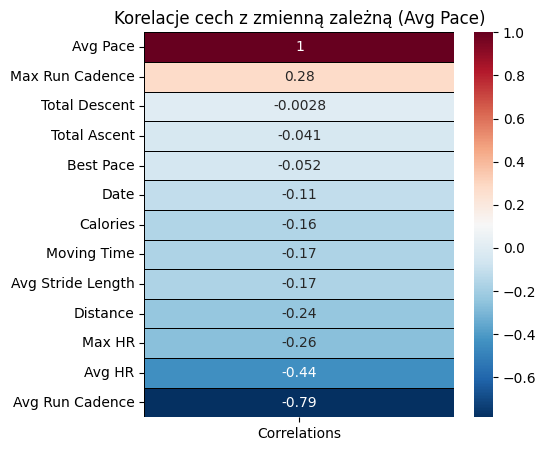

In [ ]:
corr = df.corrwith(df['Avg Pace']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = "RdBu_r",linewidths = 0.4,linecolor = 'black');
plt.title('Korelacje cech z zmienną zależną (Avg Pace)');

In [ ]:
df.isna().sum()

Date                   0
Distance               0
Calories               7
Time                   0
Avg HR                 0
Max HR                 0
Avg Run Cadence        3
Max Run Cadence        3
Avg Pace               2
Best Pace              1
Total Ascent         162
Total Descent        257
Avg Stride Length      0
Moving Time            0
dtype: int64

**Outlier detection**

In [ ]:
# Define a Z-score threshold for outlier detection
z_score_threshold = 3  # As the rule from thumb say

# Apply the detect_outliers function to each numerical column
numerical_columns = df.select_dtypes(include='number')
outliers = numerical_columns.apply(detect_outliers)

In [ ]:
# Find the rows in df where are some outlier vaules
outliers_rows = outliers[outliers.any(axis=1)]

In [ ]:
df.shape[0]

1052

In [ ]:
print(f'There are {len(outliers_rows)} outliers, which is {round(len(outliers_rows)/df.shape[0]*100, 2)}% of whole data.')

There are 112 outliers, which is 10.65% of whole data.


In [ ]:
# Create column where there are outlier
df['Has_Outlier'] = df.index.isin(outliers_rows.index)

In [ ]:
df_clear = df[df['Has_Outlier'] == False]

In [ ]:
df['Has_Outlier'].unique()

array([False,  True])

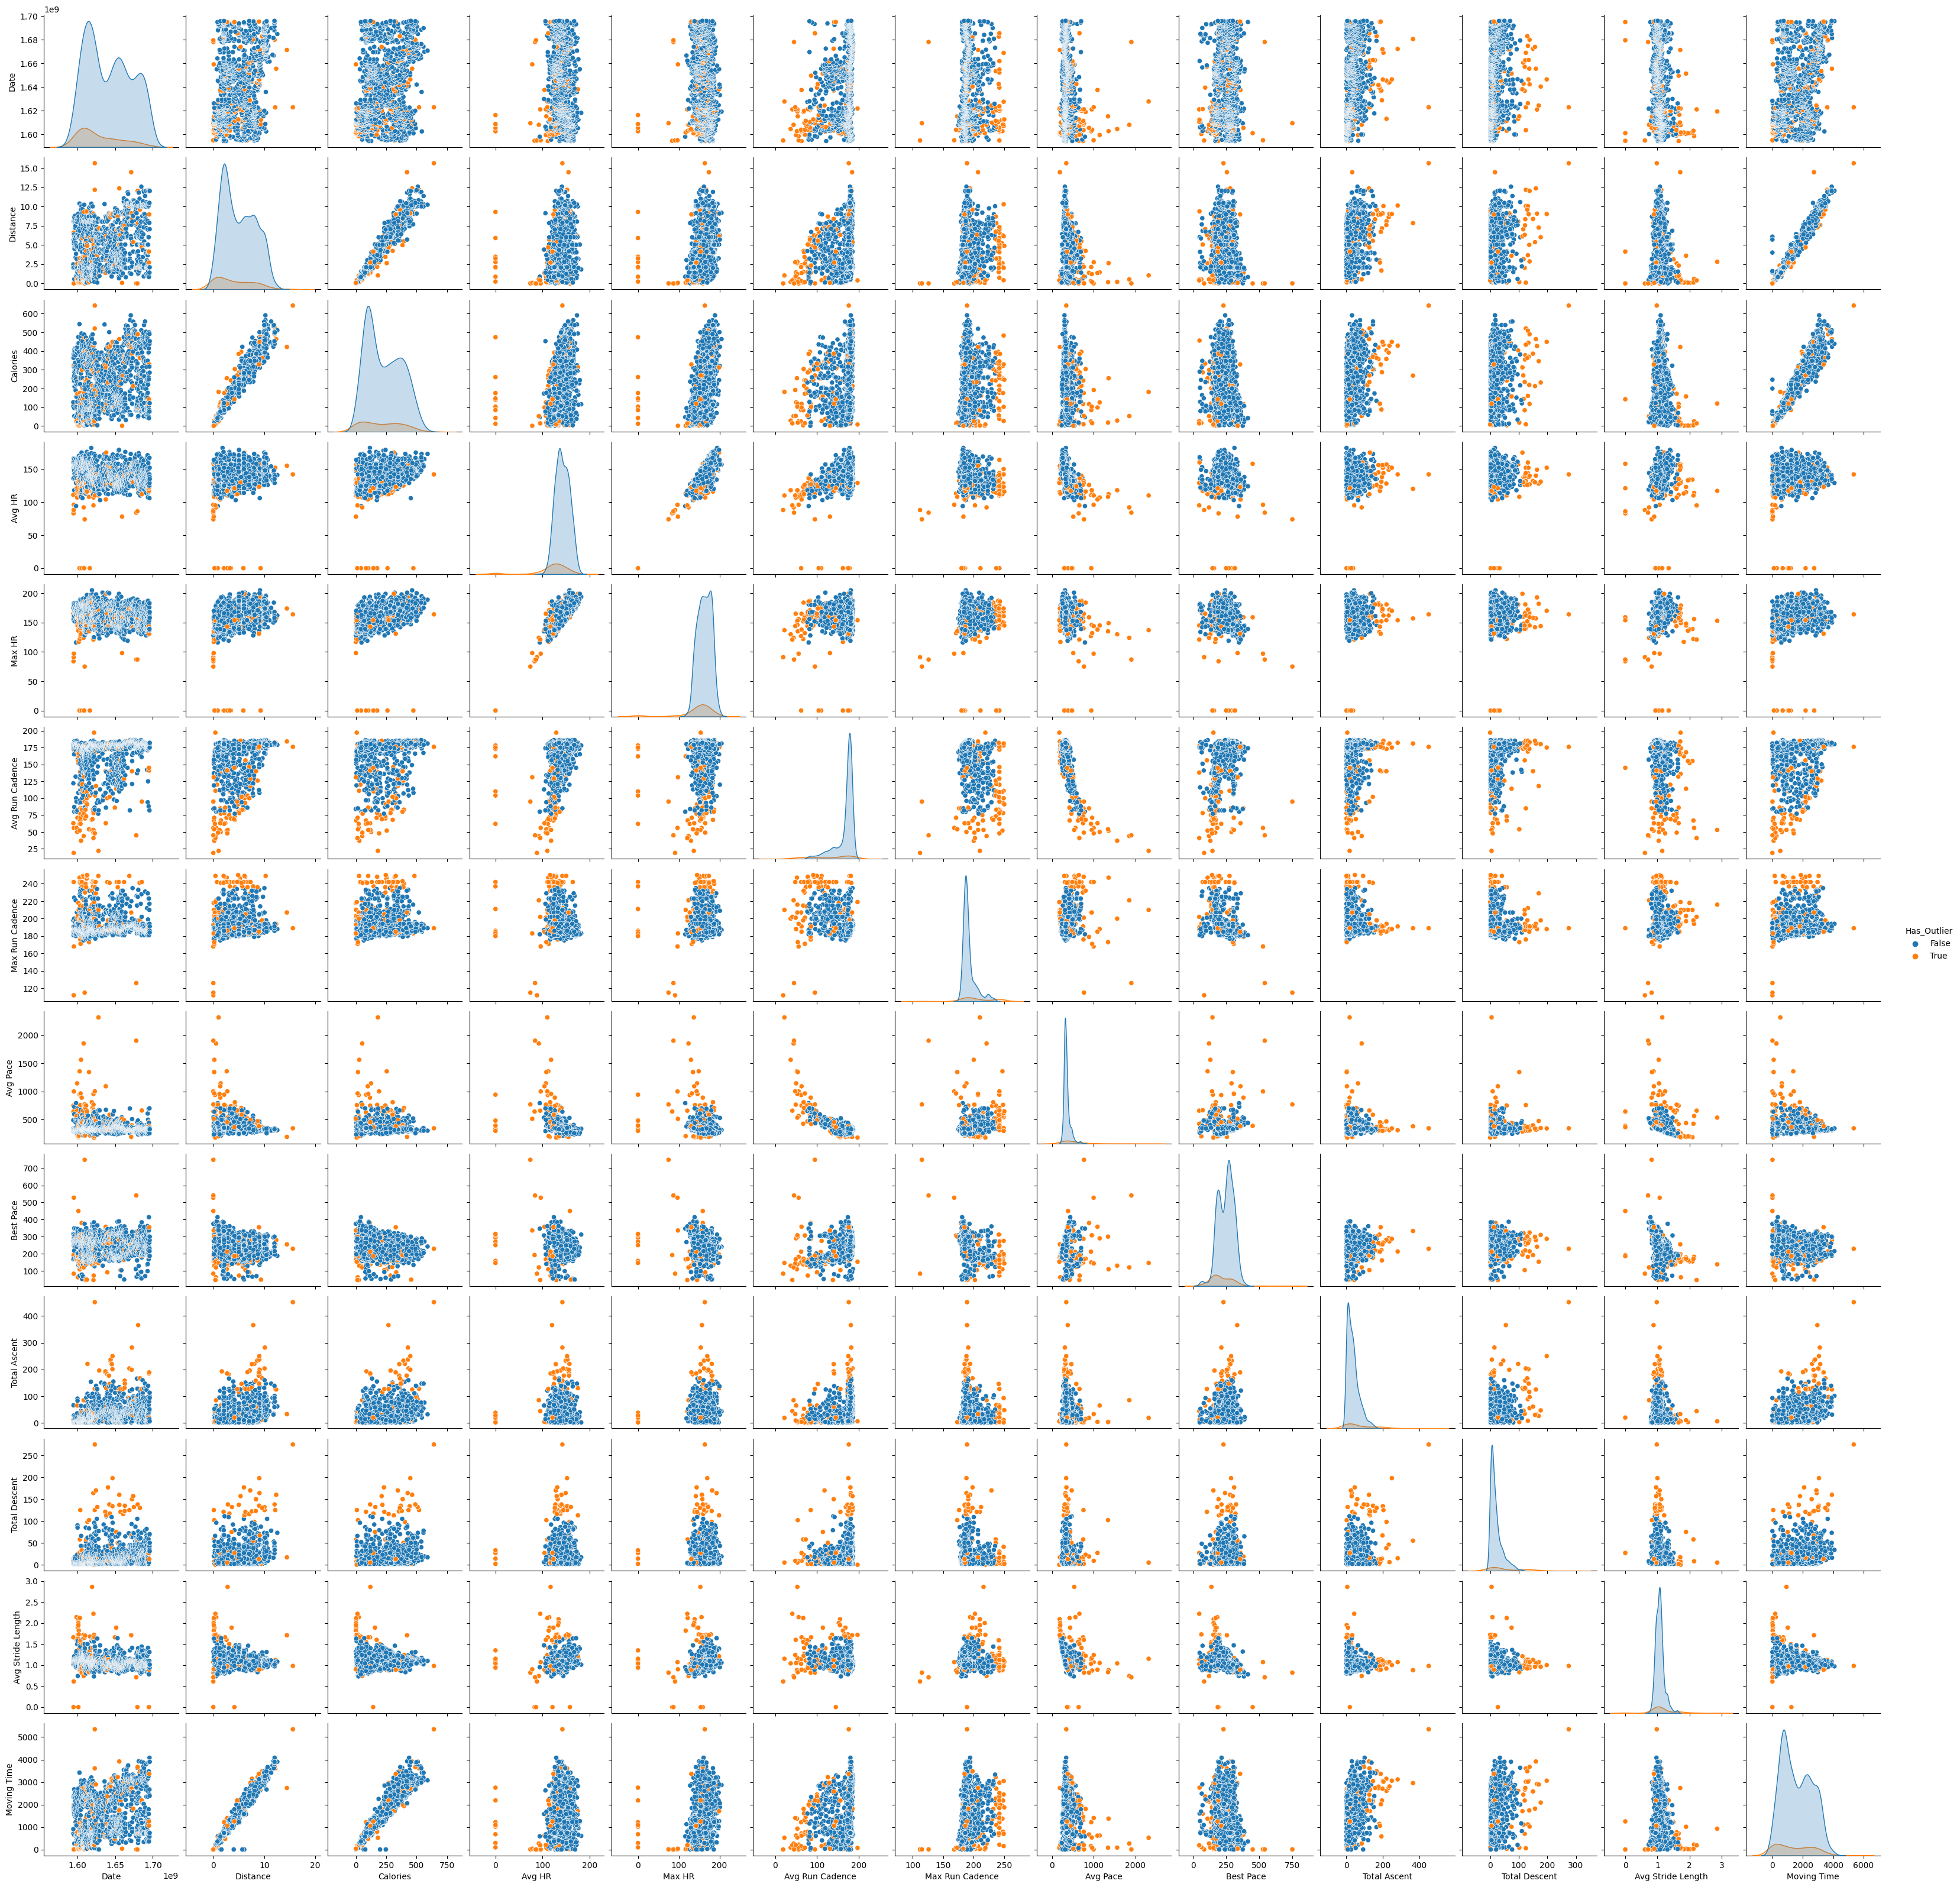

In [ ]:
sns.pairplot(df, hue="Has_Outlier")

In [ ]:
df_clear = df_clear.drop('Has_Outlier', axis=1)

In [ ]:
df = df_clear

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 1 to 1182
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1052 non-null   int64  
 1   Distance           1052 non-null   float64
 2   Calories           1052 non-null   float64
 3   Time               1052 non-null   object 
 4   Avg HR             1052 non-null   int64  
 5   Max HR             1052 non-null   int64  
 6   Avg Run Cadence    1052 non-null   float64
 7   Max Run Cadence    1052 non-null   float64
 8   Avg Pace           1052 non-null   float64
 9   Best Pace          1052 non-null   float64
 10  Total Ascent       926 non-null    float64
 11  Total Descent      838 non-null    float64
 12  Avg Stride Length  1052 non-null   float64
 13  Moving Time        1052 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 123.3+ KB


In [ ]:
df = df.drop(columns = ['Calories', 'Time', 'Avg HR', 'Avg Run Cadence', 'Best Pace', 'Moving Time'])

In [ ]:
df

Date  Distance  Max HR  Max Run Cadence  Avg Pace  Total Ascent  \
1     1594230153      2.48     156            198.0     488.0           NaN   
2     1594231455      2.06     175            181.0     336.0           NaN   
4     1594455707      8.05     183            185.0     293.0          66.0   
5     1594665089      5.63     161            181.0     317.0           5.0   
9     1594924470      8.09     178            184.0     296.0          28.0   
...          ...       ...     ...              ...       ...           ...   
1178  1695553226     10.46     183            185.0     256.0          51.0   
1179  1695626273     12.04     161            194.0     342.0         101.0   
1180  1695800297      2.10     166            186.0     353.0         113.0   
1181  1695801104      7.05     168            184.0     342.0           6.0   
1182  1695886689     12.01     158            191.0     326.0          94.0   

      Total Descent  Avg Stride Length  
1               NaN               1.11  
2               NaN               1.02  
4               2.0               1.14  
5               3.0               1.09  
9              14.0               1.17  
...             ...                ...  
1178           50.0               1.31  
1179           34.0               0.97  
1180           31.0               0.94  
1181           70.0               1.00  
1182           50.0               1.01  

[1052 rows x 8 columns]

**Median imputation**

In [ ]:
df = df.fillna(df.median())

# Data splitting

In [ ]:
X = df.drop('Avg Pace', axis =1)
y = df['Avg Pace']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_val = scaler.transform(X_val)

In [ ]:
df.columns

Index(['Date', 'Distance', 'Avg HR', 'Max HR', 'Avg Run Cadence',
       'Max Run Cadence', 'Avg Pace', 'Best Pace', 'Total Ascent',
       'Total Descent', 'Avg Stride Length', 'Moving Time'],
      dtype='object')

# LSTM

In [ ]:
import time

In [ ]:
model = Sequential()

# Input shape for LSTM is (number_of_time_steps, number_of_features)
# Since this is the first layer, you need to specify input_shape
model.add(LSTM(150, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 150)               91200     
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start_time = time.time()

# Make predictions using the model
# Dopasowanie modelu do danych treningowych
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_data=(X_val, y_val))
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken for training: {elapsed_time*1000} ms")

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 1.0141 - val_loss: 0.9818
Epoch 2/200
1/1 [==============================] - 0s 49ms/step - loss: 0.9996 - val_loss: 0.9686
Epoch 3/200
1/1 [==============================] - 0s 46ms/step - loss: 0.9873 - val_loss: 0.9568
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 0.9767 - val_loss: 0.9462
Epoch 5/200
1/1 [==============================] - 0s 46ms/step - loss: 0.9675 - val_loss: 0.9363
Epoch 6/200
1/1 [==============================] - 0s 50ms/step - loss: 0.9593 - val_loss: 0.9267
Epoch 7/200
1/1 [==============================] - 0s 52ms/step - loss: 0.9518 - val_loss: 0.9165
Epoch 8/200
1/1 [==============================] - 0s 65ms/step - loss: 0.9446 - val_loss: 0.9053
Epoch 9/200
1/1 [==============================] - 0s 48ms/step - loss: 0.9373 - val_loss: 0.8928
Epoch 10/200
1/1 [==============================] - 0s 53ms/step - loss: 0.9297 - val_loss: 0.8783
Epoch 11/200
1/1 [===

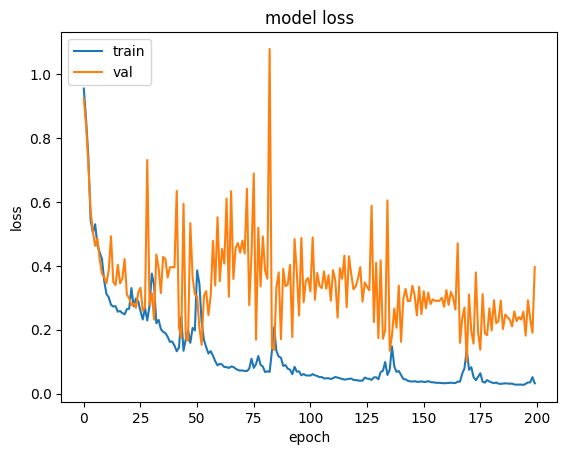

In [ ]:
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 7ms/step


In [ ]:
evaluation = evaluate_regression(y_test, y_pred)

In [ ]:
for metrics, value in evaluation.items():
  print(round(value, 4))

0.1745
0.1862
0.4178
0.8255
0.8341
0.0874


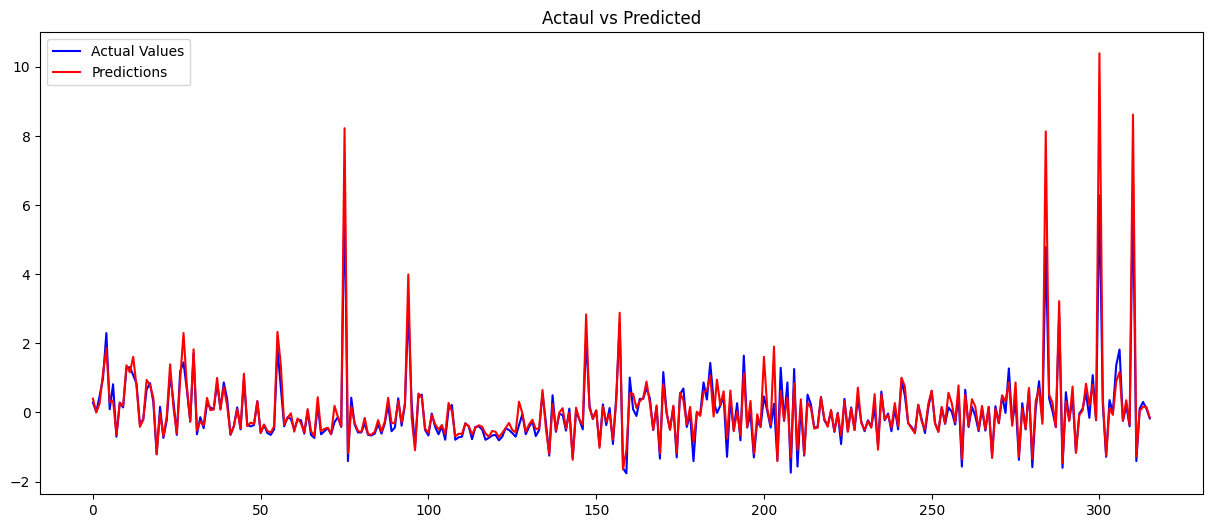

In [ ]:
plot_evaluation(y_test, y_pred)

# MLP

In [ ]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                704       
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start_time = time.time()

# Make predictions using the model
# Dopasowanie modelu do danych treningowych
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken for training: {elapsed_time*1000} ms")

Epoch 1/200
5/5 [==============================] - 2s 84ms/step - loss: 1.3425 - mae: 0.7144 - val_loss: 1.1642 - val_mae: 0.6036
Epoch 2/200
5/5 [==============================] - 0s 21ms/step - loss: 1.0794 - mae: 0.5697 - val_loss: 0.9778 - val_mae: 0.4928
Epoch 3/200
5/5 [==============================] - 0s 21ms/step - loss: 0.9283 - mae: 0.4618 - val_loss: 0.8459 - val_mae: 0.4233
Epoch 4/200
5/5 [==============================] - 0s 21ms/step - loss: 0.8189 - mae: 0.3992 - val_loss: 0.7586 - val_mae: 0.3896
Epoch 5/200
5/5 [==============================] - 0s 32ms/step - loss: 0.7480 - mae: 0.3704 - val_loss: 0.6966 - val_mae: 0.3713
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.6811 - mae: 0.3438 - val_loss: 0.6513 - val_mae: 0.3545
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6434 - mae: 0.3231 - val_loss: 0.6093 - val_mae: 0.3360
Epoch 8/200
5/5 [==============================] - 0s 19ms/step - loss: 0.5967 - mae: 0.30

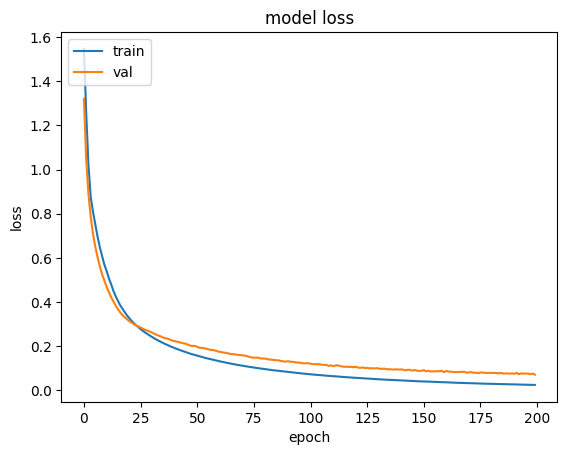

In [ ]:
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [ ]:
evaluation = evaluate_regression(y_test, y_pred)

In [ ]:
for metrice, value in evaluation.items():
  print(f'{value: .4}')

 0.01902
 0.08838
 0.1379
 0.981
 0.981
 0.05413


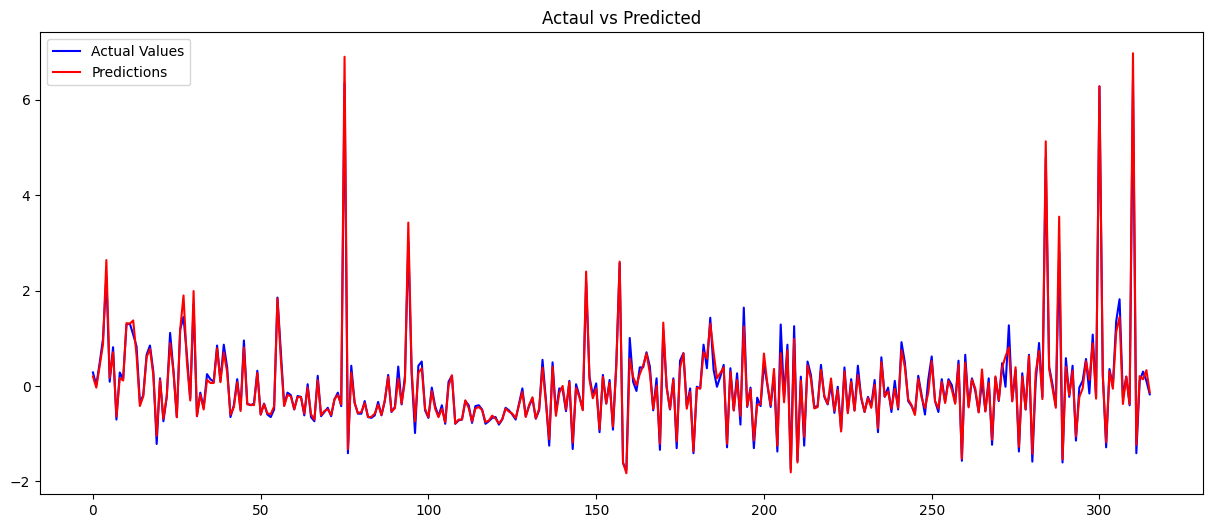

In [ ]:
plot_evaluation(y_test, y_pred)

#CNN


In [ ]:
# Define the Convolutional Neural Network model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             128       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16641 (65.00 KB)
Trainable params: 16641

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Record the start time
start_time = time.time()

# Make predictions using the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken for predictions: {elapsed_time*1000} ms")

Epoch 1/200
5/5 [==============================] - 0s 50ms/step - loss: 0.0195 - mae: 0.0263 - val_loss: 0.0755 - val_mae: 0.1406 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 0s 21ms/step - loss: 0.0193 - mae: 0.0257 - val_loss: 0.0770 - val_mae: 0.1481 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0192 - mae: 0.0271 - val_loss: 0.0791 - val_mae: 0.1510 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0191 - mae: 0.0278 - val_loss: 0.0765 - val_mae: 0.1454 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0189 - mae: 0.0272 - val_loss: 0.0780 - val_mae: 0.1474 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0186 - mae: 0.0266 - val_loss: 0.0769 - val_mae: 0.1498 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 0s 22ms/step - loss: 0.0184 - mae: 0.0268 - val_loss: 0.0738 - val_mae: 0.1438 - lr: 0.0010

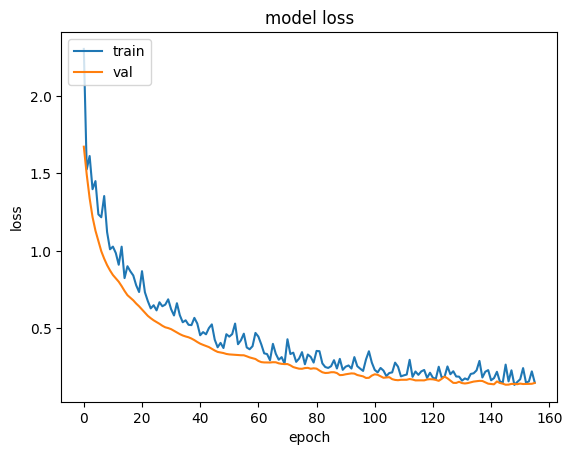

In [ ]:
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
evaluation = evaluate_regression(y_test, y_pred)
for metrics, value in evaluation.items():
  print(f'{value: .4f}')

 0.0417
 0.1361
 0.2042
 0.9583
 0.9585
 0.0801


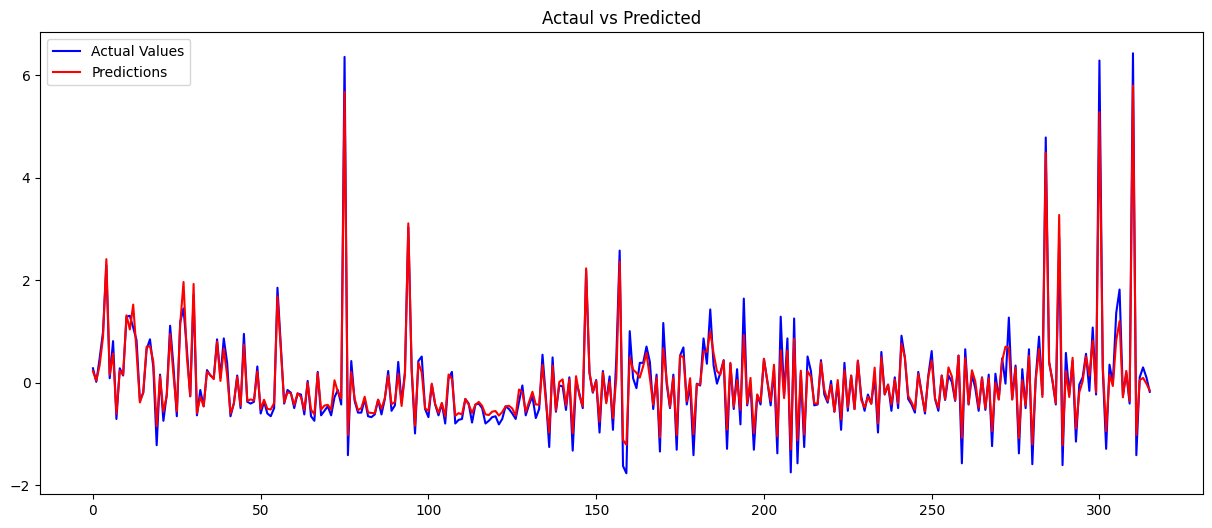

In [ ]:
plot_evaluation(y_test, y_pred)

# Polynomial regression

In [ ]:
poly = PolynomialFeatures()

In [ ]:
# Polynomial Degree
degree = 2

# Przygotowanie cech wielomianowych
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

In [ ]:
# Record the start time
start_time = time.time()

# Make predictions using the model
model.fit(X_train_poly, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken for : {elapsed_time*1000} ms")

Time taken for predictions: 28.805017471313477 ms


In [ ]:
# Record the start time
start_time = time.time()

# Make predictions using the model
y_pred = model.predict(X_test_poly)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken for predictions: {elapsed_time*1000} ms")

Time taken for predictions: 5.535125732421875 ms


In [ ]:
evaluation = evaluate_regression(y_test, y_pred)

In [ ]:
coefficients = model.coef_
intercept = model.intercept_

print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')

Intercept: [2278.7888]
Coefficients: [[-2.27892139e+03 -1.37457967e+00 -4.06125635e-02 -8.77656043e-04
  -3.95696461e-01  7.70502239e-02  6.54062629e-03 -3.40187550e-03
   1.76858604e-02 -2.97390133e-01  1.30803323e+00 -8.38895023e-01
  -1.64841831e-01  1.06448025e-01 -2.15993077e-01  1.91574216e-01
   1.32715315e-01  1.69358239e-01  8.91081169e-02  1.23069093e-01
   1.38187659e+00  6.50125518e-02 -1.32594198e-01  2.05579311e-01
  -7.08315223e-02 -4.42748964e-02 -3.95159423e-02  3.51502001e-03
  -7.21195638e-02  1.91751391e-01  6.03196472e-02 -4.27727252e-02
   2.96434462e-02  1.37870405e-02  1.34017169e-02  3.75647843e-02
   1.02410078e-01 -1.56258106e-01  4.07999754e-02 -1.81103945e-02
  -2.08819360e-02 -1.81193873e-02 -2.22901516e-02  6.50514960e-02
   1.93203658e-01 -2.79669166e-02  1.26644969e-02  1.46366209e-02
   4.21570092e-02  3.39214876e-03 -1.76254511e-01  6.96249306e-04
  -1.17446482e-03  1.67833045e-02  2.26271600e-02 -1.38328910e-01
   8.26001167e-04  1.79059356e-02  2.32

In [ ]:
for metrics, value in evaluation.items():
  print(f"{value: .4}")

In [ ]:
plot_evaluation(y_test, y_pred)

In [ ]:
from sklearn.model_selection import cross_val_score

# Ocena modelu za pomocą walidacji krzyżowej
cv_scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')

# Wyświetlenie wyników
print("Cross-Validation Scores:")
print(cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

In [ ]:
check = scaler.inverse_transform(check)

In [ ]:
prediction_1 = model.predict(check)

In [ ]:
prediction_1 = model.predict(check)
prediction_1/4.98

In [ ]:
prediction_1/60

In [ ]:
y_pred = model.predict(X_test)